In [1]:
import os
import time
import numpy as np
import sklearn
from PIL import Image
import random

import torch
import torchvision

import os
import torch
import numpy as np
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as T
import torch.nn.functional as F

from ig_pkg.datasets import get_datasets

from ig_pkg.models.generator import get_model
from ig_pkg.models.classifier import get_classifier
from ig_pkg.models.pretrained_models import get_pretrained_model

from ig_pkg.inputattribs.ig import ig
from ig_pkg.inputattribs.baseline_generator import get_baseline_generator

from ig_pkg.misc import process_heatmap, normalize_tensor, convert_to_img, label_to_class, tran, na_imshow

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]


In [15]:
train_dataset, valid_dataset = get_datasets(name= 'celebAHQ_whole', data_path = '/root/data/whole') # 3819,2398 
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

In [19]:
class_path = '/root/data/celebahq_identity/identity_whole.npy'
class_names = np.load(class_path)

for i, (inputs, labels) in enumerate(train_dataloader):
    img_train = inputs[-1]
    idx_train = np.array(labels[-1])
    pred_train = label_to_class(torch.reshape(labels[-1], (-1,1)), class_names)
    print(labels[-1])
    print(idx_train)
    print(pred_train)
    img_test = inputs[:9]
    idx_test = np.array(labels[:9])
    pred_test = label_to_class(torch.reshape(labels[:9], (-1,1)), class_names)
    print(labels[:9])
    print(idx_test)
    print(pred_test)
    break
        
### check index is not wrong
# plt.figure()
# temp = convert_to_img(img_train)
# plt.imshow(temp)

# plt.figure()
# path_a2 = os.path.join('/root/data/whole/', pred_train[0])
# a2 = os.listdir(path_a2)
# temp2 = Image.open(os.path.join(path_a2, a2[0]))
# plt.imshow(temp2)

tensor(273)
273
['1920']
tensor([ 202,  326, 1351, 2524, 2118,  526, 1402, 1157, 1456])
[ 202  326 1351 2524 2118  526 1402 1157 1456]
['1727', '2088', '3714', '5011', '4581', '2529', '3772', '347', '3835']


In [36]:
## add 2 images whose identites are the same as train

path_a2 = os.path.join('/root/data/whole/', pred_train[0])
a2 = os.listdir(path_a2)
temp2 = Image.open(os.path.join(path_a2, a2[0]))
temp3 = Image.open(os.path.join(path_a2, a2[-1]))

transform = T.Compose([T.Resize(224),T.CenterCrop(224),
                T.ToTensor(), T.Normalize(IMAGENET_MEAN, IMAGENET_STD)])

img_temp2 = transform(temp2)
img_temp3 = transform(temp3)

temp4 = torch.cat((img_temp2.unsqueeze(0), img_temp3.unsqueeze(0)), dim = 0)
img_test = torch.cat((img_test, temp4), dim = 0)
pred_test.append(pred_train[0])
pred_test.append(pred_train[0])

['1727',
 '2088',
 '3714',
 '5011',
 '4581',
 '2529',
 '3772',
 '347',
 '3835',
 '1920',
 '1920']

In [37]:
array_train = np.array(torch.reshape(img_train, (1, -1)))

list_test = []
for i in range(img_test.size(0)):
    list_test.append(torch.reshape(img_test[i], (1, -1)))
array_test = np.concatenate(list_test)



In [40]:
from sklearn.neighbors import KNeighborsClassifier

In [47]:
start_time = time.time()

for k in range(2, 10):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(array_test, pred_test)
    print(knn.predict(array_train))
    print(time.time() - start_time)

    
#     knn = KNeighborsClassifier(n_neighbors=3)
# knn.fit(array_test, pred_test)
# knn.predict(array_train) # predict labels on the test images
# # and now print the classification accuracy, which is the average number
# # of examples that are correctly predicted (i.e. label matches)
# # print('accuracy: %f' % (np.mean(y_test_pred == y_test)))


['1727']
7.645131826400757
['1727']
15.246145725250244
['1920']
22.4461932182312
['1920']
29.113699674606323
['1920']
35.61915564537048
['1920']
41.82230591773987
['1920']
47.77797079086304
['1920']
53.677605628967285


# Test for whole dataset

In [3]:
train_dataset, valid_dataset = get_datasets(name= 'celebAHQ_whole', data_path = '/root/data/whole') # 3819,2398 
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

class_path = '/root/data/celebahq_identity/identity_whole.npy'
class_names = np.load(class_path)

list_train = []
list_label = []

for i, (inputs, labels) in enumerate(train_dataloader):
#     list_label.append(label_to_class(torch.reshape(labels, (-1,1)), class_names))
    list_label = list_label + label_to_class(torch.reshape(labels, (-1,1)), class_names)

    for j in range(inputs.size(0)):
        list_train.append(torch.reshape(inputs[j], (1, -1)))
    if not (i % 20): print(i)

array_test = np.concatenate(list_train)
del list_train

print(array_test.shape)


0
20
40
60
80
100
(7592, 150528)


In [15]:
from sklearn.neighbors import KNeighborsClassifier

for k in range(2, 10):
    start_time = time.time()
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(array_test, lab) ### list_label
    print(k)
    print(time.time() - start_time)
#     break

2
0.3906409740447998
3
0.4200766086578369
4
0.4402599334716797
5
0.3757438659667969
6
0.36870837211608887
7
0.3703584671020508
8
0.36510300636291504
9
0.3657112121582031


# Use gan

In [18]:
gen_name='stylegan'
gen_path='/root/pretrained/stylegan-celebahq-1024x1024.pt'
gen_res=1024
device = 'cuda:1'
batch_size = 5

gen = get_model(gen_name, gen_path, gen_res).to(device)

latent = torch.rand((batch_size, 512)).to(device)
images = gen(latent).to(device)    

transform = T.Compose([
            T.Resize(224, interpolation=T.functional.InterpolationMode.BILINEAR, antialias=True),
            T.CenterCrop(224),
            tran,
            T.Normalize(IMAGENET_MEAN, IMAGENET_STD)
        ])
images = transform(images).to('cpu')


In [33]:
# convert image(tensor) to array(batch size, -1)
# images.size()

gan_1 = []
for i in range(images.size(0)):
    gan_1.append(torch.reshape(images[i], (1, -1)).detach().numpy())
# print(gan_1[0].size())

gan_2 = np.concatenate(gan_1)
del gan_1

(5, 150528)

<Figure size 640x480 with 0 Axes>

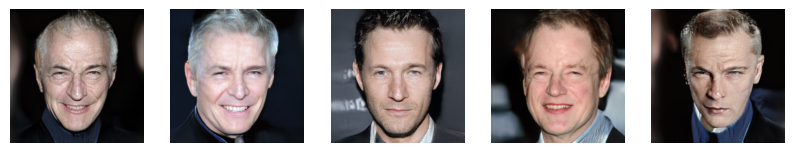

<Figure size 640x480 with 0 Axes>

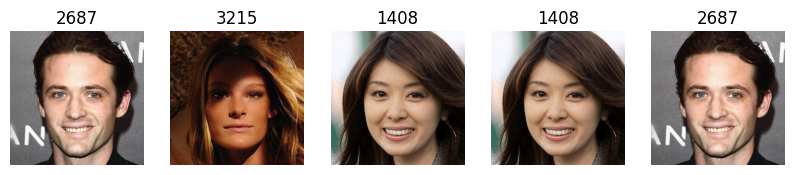

In [47]:
from sklearn.neighbors import KNeighborsClassifier

plt.figure()
fig, axes = plt.subplots(1, 5, figsize = (10,2))
axes = axes.flat

for i in range(5):
    ax = next(axes)
    x = images[i]    
    imga = convert_to_img(x)
    ax.imshow(imga)
    if i == 0: ax.set_ylabel('generated')
    ax.axis("off")

for k in range(2, 10):
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn.fit(array_test, lab) ### list_label
    predicted = knn.predict(gan_2)

    original_img_path = '/root/data/whole'
    plt.figure()
    fig, axes = plt.subplots(1, 5, figsize = (10,2))
    axes = axes.flat
    for i in range(5):
        img_directory = os.path.join(original_img_path, predicted[i])    
        img_path_list = os.listdir(img_directory)
        img_path = os.path.join(img_directory, img_path_list[0])
        imga = Image.open(img_path)
        ax = next(axes)
        ax.imshow(imga)    
        if i == 0: ax.set_ylabel(str(k))
        ax.set_title(predicted[i])
        ax.axis("off")
    break
    del knn
    

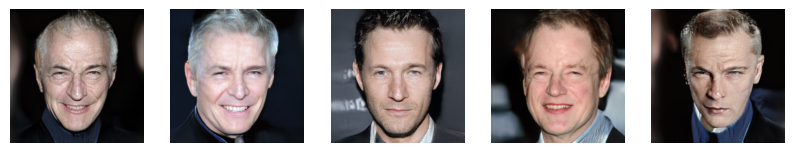

In [37]:
fig, axes = plt.subplots(1, 5, figsize = (10,2))
axes = axes.flat

for i in range(5):
    ax = next(axes)
    x = images[i]    
    imga = convert_to_img(x)
    ax.imshow(imga)
    if i == 0: ax.set_ylabel('generated')
    ax.axis("off")

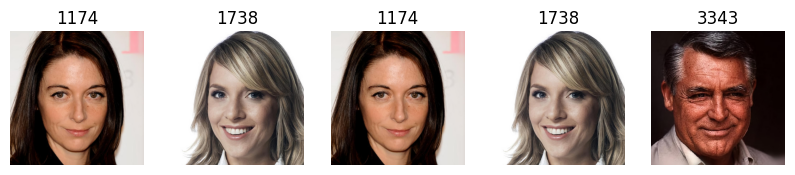

In [40]:
original_img_path = '/root/data/whole'
predicted = ['1174', '1738', '1174', '1738', '3343']
fig, axes = plt.subplots(1, 5, figsize = (10,2))
axes = axes.flat
for i in range(5):
    img_directory = os.path.join(original_img_path, predicted[i])    
    img_path_list = os.listdir(img_directory)
    img_path = os.path.join(img_directory, img_path_list[0])
    im = Image.open(img_path)
    ax = next(axes)
    ax.imshow(im)    
#     if i == 0: ax.set_ylabel(str(mode_i))
    ax.set_title(predicted[i])
    ax.axis("off")

# MISC

In [13]:
# b = list_label[0] + list_label[1]
# len(b)
lab = []
for i in range(len(list_label)):
    lab = lab + list_label[i]
len(lab)

7592

In [16]:
import torch
import torch.nn.functional as F
import torchvision.transforms as T

from tqdm import tqdm

import numpy as np

from ig_pkg.models.generator import get_model
from ig_pkg.models.classifier import get_classifier
from ig_pkg.models.pretrained_models import get_pretrained_model

from ig_pkg.loss.focal_loss import FocalLoss
from ig_pkg.loss.metrics import ArcMarginProduct, AddMarginProduct

from ig_pkg.inputattribs.ig import ig
from ig_pkg.inputattribs.baseline_generator import get_baseline_generator

from ig_pkg.misc import process_heatmap, normalize_tensor, convert_to_img, label_to_class, pipeline_figure, na_imshow, tran


from PIL import Image
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import os
import torch
import torch.nn.functional as F
import numpy as np

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

def one_shot(gen_name, gen_path, gen_res,
             batch_size, 
             class_path,
             to_device = True,
            ):
    if to_device:
        device = "cuda:0"
    else: device = "cpu"
    
    gen = get_model(gen_name, gen_path, gen_res).to(device)
    
    latent = torch.rand((batch_size, 512)).to(device)
    images = gen(latent).to(device)    
    
    transform = T.Compose([
                T.Resize(classifier_size, interpolation=T.functional.InterpolationMode.BILINEAR, antialias=True),
                T.CenterCrop(classifier_size),
                tran,
                T.Normalize(IMAGENET_MEAN, IMAGENET_STD)
            ])
    images = transform(images)
    
    class_names = np.load(class_path)
    
    score = classifier(images)#.to("cpu")        
    label = torch.argmax(score, dim = 1)
    predicted = label_to_class(label, class_names)
    
    res = {'gen_img': images,
           'pred': predicted,
    }
    return res
